<a href="https://colab.research.google.com/github/GurkiratSarna/CE888-Decision-Making-UoE/blob/master/Lab_8/TransferLearning_Example1%26Exercise2_cats%26dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer Learning using Cats and Dogs dataset

In [0]:
import os
#!rm -r CE888_2020
#!rm -rf data

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "gurkiratsarna" # username from the json file
os.environ['KAGGLE_KEY'] = "704aca2803d9d723440ca20977f69914" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 34.6MB/s]
 98% 265M/271M [00:07<00:00, 31.4MB/s]
100% 271M/271M [00:07<00:00, 36.5MB/s]
 97% 529M/543M [00:10<00:00, 60.6MB/s]
100% 543M/543M [00:10<00:00, 52.4MB/s]


In [3]:
# Unzip the data from train.zip to current directory /content
from zipfile import ZipFile

file_name = "/content/train.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [1]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

     |████████████████████████████████| 43.6MB 109kB/s 
     |████████████████████████████████| 1.6MB 52.6MB/s 
     |████████████████████████████████| 890kB 54.3MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=21a35cdcd202b328e5c9dd83c0d145ea86e55e08c28ed449ef89b61889e7ce8b
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: stable-baselines 2.2.1 has requirement tensorflow>=1.5.0, but you'll have tensorflow 1.3.0 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.3.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.3.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: html5

In [5]:
!git clone https://github.com/sagihaider/CE888_2020.git # get vgg file - uploaded it on my github

Cloning into 'CE888_2020'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 25162 (delta 36), reused 4 (delta 0), pack-reused 25082
Receiving objects: 100% (25162/25162), 562.19 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [0]:
#!rm -r CE888_2020

In [2]:
import numpy as np
import os
import time
from vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarn

In [4]:
#%% Load an image as an example and see the image-processing

img_path = '/content/train/cat.1.jpg' # image name

#very less documentation available, 3 maybe the total dimensions needed to define the shape - check.
img = image.load_img(img_path, target_size=(224, 224)) # load image of size (img_height, img_width)

x = image.img_to_array(img) # convert image to array
print (x.shape)

x = np.expand_dims(x, axis=0) # expand dimension
print (x.shape)

x = preprocess_input(x)
print('Input image shape:', x.shape) # the first number is the number of images = 1 here.

(224, 224, 3)
(1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)


In [5]:
#%% Loading the training data
PATH = os.getcwd()
PATH

'/content'

Create two folders for cats and dogs with 2000 samples of images each.

In [0]:
#Create a data folder that will contain 2 folders - cats and dogs
original_dataset_dir = '/content/train'
base_dir = '/content/data'
os.mkdir(base_dir)

In [0]:
#create cats and dogs folder under data folder
dogs_dir = os.path.join(base_dir, 'dogs')
os.mkdir(dogs_dir)

cats_dir = os.path.join(base_dir, 'cats')
os.mkdir(cats_dir)

In [8]:
original_dataset_dir

'/content/train'

In [9]:
cats_dir

'/content/data/cats'

In [10]:
dogs_dir

'/content/data/dogs'

In [0]:
import shutil

fnames = ['cat.{}.jpg'.format(i) for i in range(2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(cats_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(dogs_dir, fname)
    shutil.copyfile(src, dst)

In [13]:
# Define data path
data_path = PATH + '/data'
data_dir_list = os.listdir(data_path)
data_dir_list

['dogs', 'cats']

In [0]:
img_data_list=[] # created an empty list for images to be loaded

In [15]:
for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
		# print('Input image shape:', x.shape)
		img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32') # only if large database
print (img_data.shape)

img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)

img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-dogs

Loaded the images of dataset-cats

(4000, 1, 224, 224, 3)
(1, 4000, 224, 224, 3)
(4000, 224, 224, 3)


In [16]:
# Define the number of classes
num_classes = 2 # cats and dogs
print(img_data.shape[0])

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels

4000


array([1, 1, 1, ..., 1, 1, 1])

In [0]:
labels[0:2000]=0
labels[2000:4000]=1

names = ['cats','dogs']

# convert class labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [18]:
#%% Fine Tuning

image_input = Input(shape=(224, 224, 3)) # shape of a single image

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet') # load VGG-16 model with 'top = true'
model.summary()

547987456/553467096 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (M

In [39]:
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [41]:
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

custom_vgg_model.layers[3].trainable
custom_vgg_model.summary()

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [42]:
t=time.time()
#	t = now()
hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 3395s - loss: 0.1238 - acc: 0.9613 - val_loss: 0.0367 - val_acc: 0.9888
Epoch 2/2
3200/3200 [==============================] - 3400s - loss: 0.0412 - acc: 0.9859 - val_loss: 0.0437 - val_acc: 0.9888
Training time: -6796.036595582962
800/800 [==============================] - 685s   
[INFO] loss=0.0437, accuracy: 98.8750%


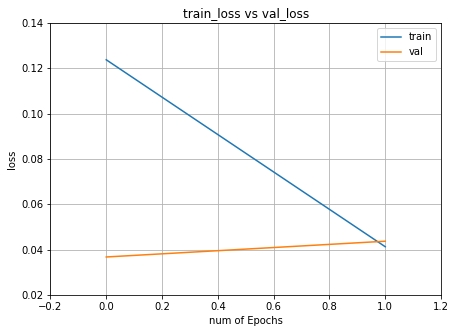

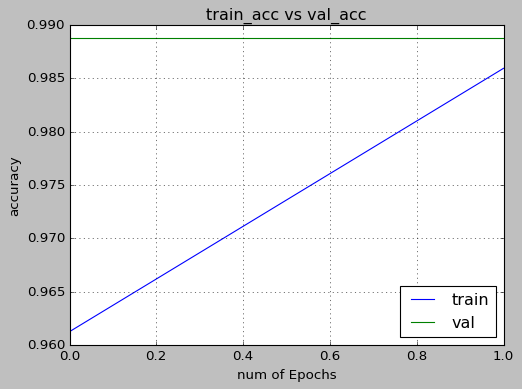

In [43]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(2)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

**TransferLearning Exercise2**

The last layer is defined with 'block5_pool'

optimizer='adadelta'

epochs=4

xc=range(4)

In [19]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
# freeze all the layers except the dense layers
for layer in custom_vgg_model2.layers[:-3]:
	layer.trainable = False

custom_vgg_model2.summary()

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
t=time.time()
#	t = now()
hist = custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=4, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 3200 samples, validate on 800 samples
Epoch 1/4
3200/3200 [==============================] - 3521s - loss: 0.8632 - acc: 0.9203 - val_loss: 0.3128 - val_acc: 0.9750
Epoch 2/4
3200/3200 [==============================] - 3488s - loss: 0.2371 - acc: 0.9747 - val_loss: 0.1690 - val_acc: 0.9788
Epoch 3/4
3200/3200 [==============================] - 3460s - loss: 0.1059 - acc: 0.9884 - val_loss: 0.1958 - val_acc: 0.9762
Epoch 4/4
3200/3200 [==============================] - 3356s - loss: 0.0570 - acc: 0.9947 - val_loss: 0.1624 - val_acc: 0.9838
Training time: -13827.341990709305
800/800 [==============================] - 695s   
[INFO] loss=0.1624, accuracy: 98.3750%


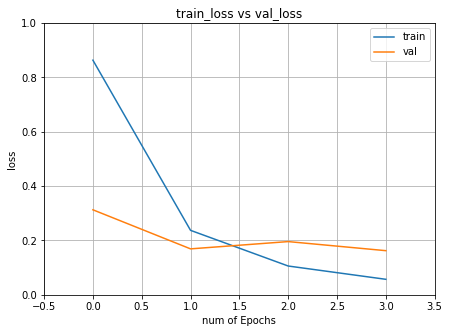

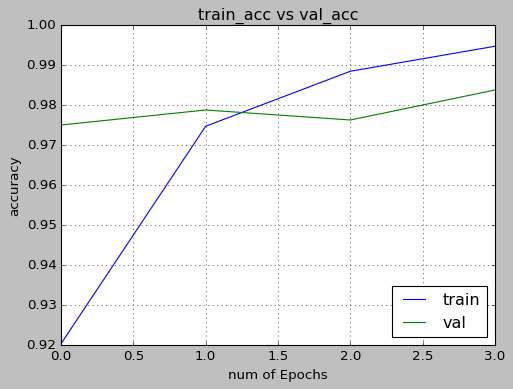

In [22]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(4)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

**Trying a diffrent optimiser for 'fc2' layer as the validation loss was same in both epochs**

In [23]:
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model3 = Model(image_input, out)
custom_vgg_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
for layer in custom_vgg_model3.layers[:-1]:
	layer.trainable = False

custom_vgg_model3.layers[3].trainable
custom_vgg_model3.summary()

from keras.optimizers import SGD
opt = SGD(lr=0.01)

custom_vgg_model3.compile(loss='categorical_crossentropy',optimizer=opt ,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
t=time.time()
#	t = now()
hist = custom_vgg_model3.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model3.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 3520s - loss: 0.0842 - acc: 0.9694 - val_loss: 0.0361 - val_acc: 0.9912
Epoch 2/2
3200/3200 [==============================] - 3457s - loss: 0.0351 - acc: 0.9866 - val_loss: 0.0331 - val_acc: 0.9900
Training time: -6977.815544605255
800/800 [==============================] - 716s   
[INFO] loss=0.0331, accuracy: 99.0000%


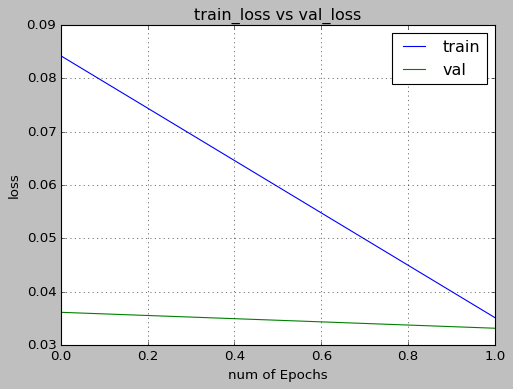

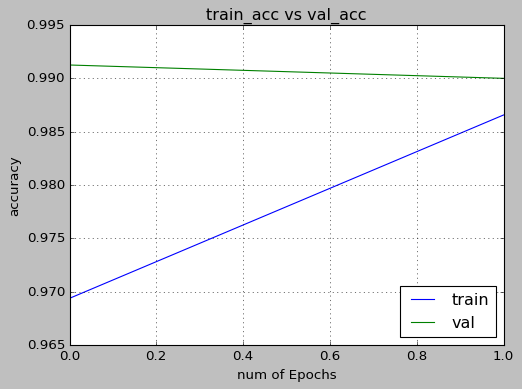

In [26]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(2)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])